In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d kedarsai/bird-species-classification-220-categories

Dataset URL: https://www.kaggle.com/datasets/kedarsai/bird-species-classification-220-categories
License(s): CC0-1.0
100% 1.05G/1.06G [00:14<00:00, 49.0MB/s]
100% 1.06G/1.06G [00:14<00:00, 76.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bird-species-classification-220-categories.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [47]:
# Paths to the train and test directories
train_directory = '/content/Train'
test_directory = '/content/Train'

# Preprocess and augment training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Preprocess test/validation images
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories and resize them to 224x224
training_set = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 9414 images belonging to 200 classes.
Found 9414 images belonging to 200 classes.


In [48]:
# Load VGG16 model pre-trained on ImageNet, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers to prevent updating during training
for layer in vgg16_base.layers:
    layer.trainable = False


In [51]:
# Build the final model
model = Sequential()

# Add the VGG16 base model
model.add(vgg16_base)

# Add a Flatten layer to convert 2D outputs to 1D
model.add(Flatten())

# Add a fully connected Dense layer
model.add(Dense(256, activation='relu'))

# Optionally add Dropout for regularization
model.add(Dropout(0.5))

# Output layer: Number of categories in the bird dataset (modify based on your dataset)
model.add(Dense(training_set.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [53]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    training_set,
    epochs=20,  # Set the number of epochs as needed
    validation_data=test_set,
    callbacks=[early_stopping]
)


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 227s 758ms/step - accuracy: 0.0042 - loss: 5.2976 - val_accuracy: 0.0056 - val_loss: 5.3025
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 187s 625ms/step - accuracy: 0.0056 - loss: 5.2988 - val_accuracy: 0.0052 - val_loss: 5.2969
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 224s 752ms/step - accuracy: 0.0046 - loss: 5.2971 - val_accuracy: 0.0052 - val_loss: 5.2969
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 220s 609ms/step - accuracy: 0.0059 - loss: 5.2961 - val_accuracy: 0.0052 - val_loss: 5.2969
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 609ms/step - accuracy: 0.0050 - loss: 5.2978 - val_accuracy: 0.0052 - val_loss: 5.2969
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 184s 613ms/step - accuracy: 0.0047 - loss: 5.2969 - val_accuracy: 0.0052 - val_loss: 5.2969
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 182s 609ms/step - accuracy: 0.0049 - loss: 5.2982 - val_accuracy: 0.0052 - val_loss: 5.2969
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 201s 603ms/step - accuracy: 0.0029 -

In [54]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.4f}")


295/295 ━━━━━━━━━━━━━━━━━━━━ 43s 146ms/step - accuracy: 0.0049 - loss: 5.2951
Test accuracy: 0.0052


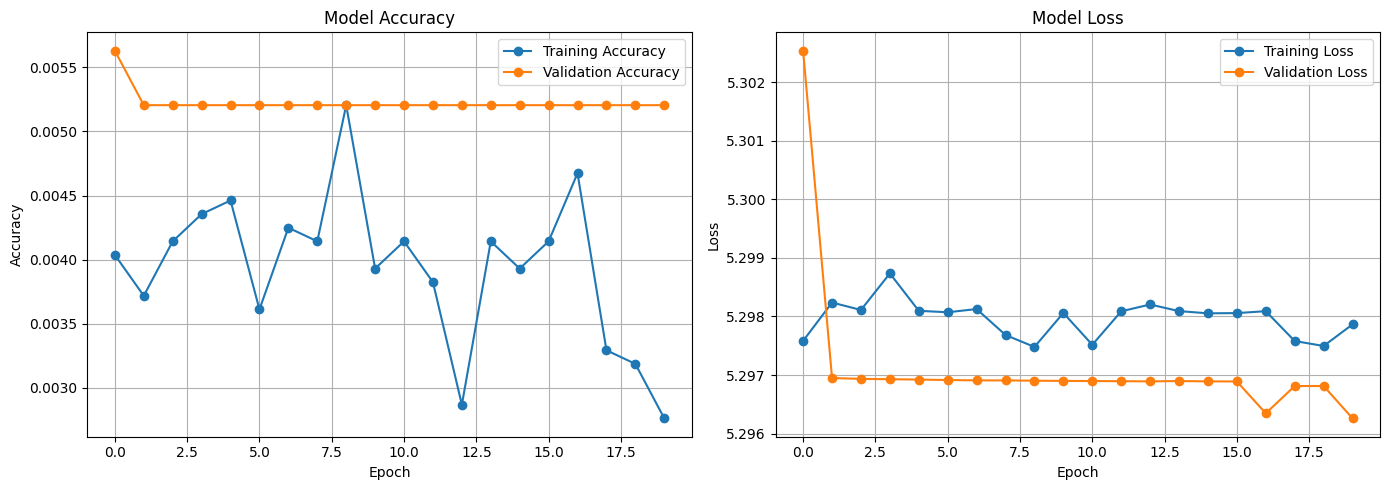

In [56]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [57]:
# Save the trained model
model.save('bird_classifier_vgg16.h5')
